# Meridional Ray Tracing using the (Q, U) method (Kingslake, Ch. 2)

This notebook implements the ray tracing equations on Kinglake Ch 2, pg26. The meanings of the various variables are as follows:

|Name|Description|
|----|-----------|
| R  | Radii of surfaces |
| c  | Curvatures (1/R) of surfaces |
| d  | Thicknesses of elements, i.e, distances between surfaces|
| n  | Refractive indices: n_k is the left medium, n_{k+1} the right medium, with surface in betweeen|
| Q  | The perpendicular distance from surface vertex to ray being traced|
| I  | Angle of incidence |
| U  | Angle of ray with optical axis|

Primed quantities are after refraction and are stored in underscored_ variables. Angles are measured positive if clockwise to normal and negative otherwise. Radii are positive to right of surface and negative to left. 

The ray tracing equations are:

* sin I = Qc - sin U
* sin I' = (n/n') * sin I
* U' = U + I - I'
* Q' = (sin U' + sin I') / c

Alternately

* Q' = Q * (cos U' + cos I') / (cos U + cos I)

Transfer:

* Q2' = Q1' - d * sin U1'



**Warning:** This code is not hardened against division by zero as can happen for paraxial rays (Q[0]=0)


In [43]:
from math import sin, asin, sqrt, cos, tan, pi
Blue=486.1
BlueGreen=520
GreenLaser=532
Green=546.1
Red=656.3
RedLaser=632

In [44]:
def r2d(x):
    return 180/pi*x


In [45]:
class Prescription:
    def __init__(self, text=None):
        if text == None:
            self.R = list()     # List of radii, starting from media[1]; media[0] is typically 'AIR'
            self.d = list()     # List of distances (thicknesses) between surfaces
            self.media = list() # List of media names, first and last are always 'AIR'
        else:
            #print('Reading prescription:', text)
            p = PrescriptionReader(text).prescription
            self.R = p.R
            self.d = p.d
            self.media = p.media
            
    def add_R(self, new_R):
        self.R.append(new_R)
    def add_d(self, new_d):
        self.d.append(new_d)
    def add_medium(self, new_medium):
        self.media.append(new_medium)
        
class BadPrescriptionError(Exception):
    def __init__(str):
        super(BadPrescriptionError, self).__init__(str)
        
class PrescriptionReader:
        '''
            Read a text description and create a Prescription object.
            
            The text description follows this grammar:
            prescription: 
                line { line }
            line: 
                medium | thickness | radius
            medium: 
                'MED' STRING
            thickness: 
                'TH' number
            radius: 
                'RAD' number
            Each of MED/TH/RAD must be specified for a surface before any entry for the next surface
            but for each surface, order doesn not matter.
            
            Specify a large number ~1e10 for "infinite". The description is for surfaces like this:
            
            | MED=AIR       | MED=SURFACE 1 MEDIUM   |     | MED=SURFACE N-1 MEDIUM    | MED=AIR
            | TH=INFINITE   | TH=SURFACE 1 THICKNESS | ... | TH= SURFACE N-1 THICKNESS | TH =INFINTE
            | RAD=INFINITE  | RAD=SURFACE 1 RADIYS   |     | RAD=SURFACE N-1 RADIUS    | RAD=SURFACE N RADIUS
            
        '''
        def __init__(self, str):
            self.text = str
            self.pos = 0
            self.prescription = Prescription()
            self.token = ''
            self.eof = False
            # State for FSM:
            #  [0]--MED-->[1]
            #   ^          |
            #   |          +--TH->[2]--RAD-------+
            #   |          |                     |
            #   |          +--RAD-->[3]--TH--+   |
            #   |                            |   |
            #   +----------------------------+   |
            #   |                                |
            #   +--------------------------------+
            self.state = 0
            self.read()
        def read(self):
            self.next_token()
            self.line()
            while not self.eof:
                self.line()
        def line(self):
            if self.token == 'MED':
                if self.state != 0:
                    raise BadPrescriptionError('unexpected MED entry')
                self.state = 1
                self.next_token()
                self.prescription.add_medium(self.token)
                self.next_token()
            elif self.token == 'TH':
                if self.state == 1:
                    self.state = 2
                elif self.state == 3:
                    self.state = 0
                else:
                    raise BadPrescriptionError('unexpected TH entry')
                self.next_token()
                fval = float(self.token)
                if fval < 1e6:
                    self.prescription.add_d(float(self.token))
                self.next_token()
            elif self.token == 'RAD':
                if self.state == 1:
                    self.state = 3
                elif self.state == 2:
                    self.state = 0
                else:
                    raise BadPrescriptionError('unexpected RAD entry')
                self.next_token()
                fval = float(self.token)
                if fval < 1e6:
                    self.prescription.add_R(float(self.token))
                self.next_token()
            else:
                raise BadPrescriptionError('bad token {}'.format(self.token))
        def skip_white_space(self):
            while not self.eof and self.text[self.pos].isspace():
                self.advance()
        def advance(self):
            self.pos += 1
            self.eof = not self.pos < len(self.text)
        def next_token(self):
            self.token = ''
            self.skip_white_space()
            while not self.eof and not self.text[self.pos].isspace():
                self.token += self.text[self.pos]
                self.advance()
        
        
def text_to_prescription(str):
        '''
        Procedure for reading a text description of the lens and converting it into a Prescription object. 
        '''
        pr = PrescriptionReader(str)
        return pr.prescription
        #print(pr.prescription.media)
        #print(pr.prescription.R)
        #print(pr.prescription.d)
        
p=Prescription('''
MED AIR
TH 1e10
RAD 1e10
MED BK7
RAD 7.3895
TH 1.05
MED SF12
RAD -5.1784
TH 0.40
MED AIR
RAD -16.2225
TH 1e10
''')
print(p.R, p.d, p.media)


[7.3895, -5.1784, -16.2225] [1.05, 0.4] ['AIR', 'BK7', 'SF12', 'AIR']


In [46]:
# Sellmeier cofficients table
Sellmeier_coeffs = {
    'AIR' : ([0.0], [0.0]),
    'BK7' : ([1.03961212, 0.231792344, 1.01046945], [0.00600069867, 0.0200179144, 103.560653]),
    'F2' : ([1.34533359, 0.209073176, 0.937357162], [0.00997743871, 0.0470450767, 111.886764]),
    'CAF2': ([0.437387571, 0.449211397, 0.152068715, 13.0020420], [0.00173799328, 0.00782718648, 0.0124086125, 4039.76541]),
    'N-ZK7': ([1.07715032, 0.168079109, 0.851889892], [0.00676601657, 0.0230642817, 89.0498778]),
    'KZFSN4': ([1.37994218, 0.168496708, 0.874885726], [0.00891159699, 0.040533407, 69.6628237]),
    'SK55': ([1.15265225, 4.32145290e-001, 1.03215169e+000], [5.82679114e-003, 1.90244615e-002, 8.81750460e+001]),
    'N-BAF4': ([1.42056328e+000,1.02721269e-001,1.14380976e+000], [9.42015382e-003,5.31087291e-002,1.10278856e+002]),
    'SF12' : ([1.39867348e+000, 2.38403762e-001, 1.03604466e+000], [1.03415646e-002, 4.92696913e-002, 1.18327782e+002])
}

# Ohara's coefficient table which uses a different formula.
OHARA_coeffs = {
    'O-FPL51': [2.2184385, -0.0059347504, 0.0080764899, 0.00016581036, -8.0553319e-06, 3.5839492e-07 ],
    'O-FPL53': [2.0531286, -0.0043190085, 0.0062752442, -9.8512972e-6, 1.364971e-5, -8.9037944e-7]
}

def n_from_lambda_nm_OHARA(wvl, name):
    '''
    OHARA doesn't use Sellmeier cofficients but a power series in (wvl^2).
    '''
    assert name[0:2] == 'O-'
    coeffs = OHARA_coeffs[name]
    n = 0.0
    wvl /= 1000.0 # The OHARA formula needs the wavelength in microns
    # The formula goes like:
    #   n^2 = A + B*wvl^2 + C*wvl^-2 + D*wvl^-4 + E*wvl^-6 + ...
    wvlsq = wvl * wvl
    n = coeffs[0] + coeffs[1] * wvlsq;
    wvl_fac = wvlsq
    for coeff in coeffs[2:]:
        n += coeff / wvl_fac
        wvl_fac *= wvlsq
    return sqrt(n)

def n_from_lambda_nm(wvl, name):
    '''
    Compute Refractive index computation by wavelength using the Sellmeier equation
    n^2= 1 + Sum(B[i]*wvl^2/(wvl^2 - C[i]))
    wvl is input in nano-meters, e.g. green is 546.0
    If the name begins with O-, compute using OHARA coefficients
    '''
    assert 300 <= wvl and wvl <= 1000;

    if name[0:2] == 'O-':
        return n_from_lambda_nm_OHARA(wvl, name)
    
    coeffs = Sellmeier_coeffs[name]
    B = coeffs[0]
    C = coeffs[1]
    assert len(B) > 0
    assert len(B) == len(C)
    n = 1.0;
    wvl /= 1000.0  # The cofficients need the wavelength in microns.
    wvlsq = wvl * wvl
    for i in range(len(B)):
        n += B[i] * wvlsq / (wvlsq - C[i])
    return sqrt(n)
    


In [47]:
%precision 6
n_from_lambda_nm(546, 'F2')

1.624088

In [48]:
def intersection_height(r1, r2, d):
    '''Given the radii r1 and r2 of a lens with axial thickness d, compute the intersection height.
    Return as (height, True) when defined and as (0.0, False) when not.'''
    A = (2*r2 + d)/(2*r1 - d)
    X2 = d/(A-1)
    X1 = A*X2
    YY = 2*r1*X1 - X1*X1
    if YY >= 0.0:
        return (sqrt(YY), True)
    return (0.0, False)

In [49]:
def meridional_ray_trace_return_all(wvl, prescription, Q_init, show_vars):
    R = prescription.R
    d = prescription.d
    medium_names = prescription.media
    NSurf = len(R)
    assert NSurf + 1 == len(medium_names)
    assert NSurf - 1 == len(d)
    # Compute curvatures
    c=[1/x for x in R]
    # Find indices
    n = [n_from_lambda_nm(wvl, medium) for medium in medium_names]
    # Initialize all to 0
    Q     = [float("NAN") for k in range(NSurf)]
    I     = [float("NAN") for k in range(NSurf)]
    I_    = [float("NAN") for k in range(NSurf)]
    U     = [float("NAN") for k in range(NSurf)]
    U_    = [float("NAN") for k in range(NSurf)]
    Q_    = [float("NAN") for k in range(NSurf)]
    Y     = [float("NAN") for k in range(NSurf)]
    X     = [float("NAN") for k in range(NSurf)]
    # Start off with first value of Q for surface 0 as Q_init; this is the height of the paraxial ray being traced
    Q[0] = Q_init
    U[0] = 0.0 # Object at infinity
    for k in range(NSurf):
        I[k] = asin(Q[k] * c[k] - sin(U[k]))
        I_[k] = asin((n[k] / n[k + 1]) * sin(I[k]))
        U_[k]=(U[k] + I[k] - I_[k])
        Q_[k]=(sin(I_[k]) + sin(U_[k])) / c[k]
        # Point of incidence
        Y[k] = sin(U[k] + I[k]) / c[k]
        X[k] = (1 - cos(U[k] + I[k])) / c[k]
        if show_vars:
            print("Surface #", k)
            print('Q = {:15.4f}'.format(Q[k]))
            print("Q'= {:15.4f}".format(Q_[k]))
            print('I = {:15.4f}'.format(r2d(I[k])))
            print("I'= {:15.4f}".format(r2d(I_[k])))
            print('U = {:15.4f}'.format(r2d(U[k])))
            print("U'= {:15.4f}".format(r2d(U_[k])))
            print("X = {:15.4f}".format(X[k]))
            print("Y = {:15.4f}".format(Y[k]))
            print('')
        # Check ray height
        if k < NSurf - 1:
            height, intersection_defined = intersection_height(R[k], R[k+1], d[k])
            if intersection_defined and Y[k] > height:
                print('ERROR: ray trace misses lens for surface ', k, '; maximum height is ', height)
                return
        # Transfer
        if k < NSurf-1:
            Q[k+1] = Q_[k] - d[k]*sin(U_[k])
            U[k+1] = U_[k]
    
    bfl = Q_[NSurf-1]/sin(U_[NSurf-1])
    if show_vars:
        print('BFL={:15.4f}'.format(bfl))
        
    return (bfl, X, Y, Q_, I_, U_)



In [50]:
def meridional_ray_trace_return_all_2(wvl, prescription, Q_init, show_vars):
    '''
    Version that avoids arcsin computations. Kinglake page 28/29. 
    Surprisingly it turns out to be slower than the other one at 21.9 microsec vs 15.9 microsec :headscratch:
    '''
    R = prescription.R
    d = prescription.d
    medium_names = prescription.media
    NSurf = len(R)
    assert NSurf + 1 == len(medium_names)
    assert NSurf - 1 == len(d)
    # Compute curvatures
    c=[1/x for x in R]
    # Find indices
    n = [n_from_lambda_nm(wvl, medium) for medium in medium_names]
    # Initialize all to 0
    Q     = [float("NAN") for k in range(NSurf)]
    sinU  = [float("NAN") for k in range(NSurf)]
    cosU  = [float("NAN") for k in range(NSurf)]
    sinI  = [float("NAN") for k in range(NSurf)]
    cosI  = [float("NAN") for k in range(NSurf)]
    sinUPlusI = [float("NAN") for k in range(NSurf)]
    cosUPlusI = [float("NAN") for k in range(NSurf)]
    sinMinusI_ = [float("NAN") for k in range(NSurf)]
    cosI_ = [float("NAN") for k in range(NSurf)]
    sinU_ = [float("NAN") for k in range(NSurf)]
    cosU_ = [float("NAN") for k in range(NSurf)]
    Q_    = [float("NAN") for k in range(NSurf)]
    Y     = [float("NAN") for k in range(NSurf)]
    X     = [float("NAN") for k in range(NSurf)]
    # Start off with first value of Q for surface 0 as Q_init; this is the height of the paraxial ray being traced
    Q[0] = Q_init
    sinU[0] = 0.0
    cosU[0] = 1.0
    for k in range(NSurf):
        sinI[k] = Q[k]*c[k] - sinU[k]
        cosI[k] = sqrt(1 - sinI[k]**2)
        sinUPlusI[k] = sinU[k]*cosI[k] + cosU[k]*sinI[k]
        cosUPlusI[k] = cosU[k]*cosI[k] - sinU[k]*sinI[k]
        sinMinusI_[k] = -n[k]/n[k+1] * sinI[k]
        cosI_[k] = sqrt(1 - sinMinusI_[k] ** 2)
        sinU_[k] = sinUPlusI[k] * cosI_[k] + cosUPlusI[k]*sinMinusI_[k]
        cosU_[k] = cosUPlusI[k] * cosI_[k] - sinUPlusI[k]*sinMinusI_[k]
        G = Q[k]/(cosU[k] + cosI[k])
        Q_[k]=G*(cosU_[k] + cosI_[k])
        # Point of incidence
        Y[k] = sinUPlusI[k] / c[k]
        X[k] = (1 - cosUPlusI[k]) / c[k]
        if show_vars:
            print("Surface #", k)
            print('Q = {:15.4f}'.format(Q[k]))
            print("Q'= {:15.4f}".format(Q_[k]))
            print("X = {:15.4f}".format(X[k]))
            print("Y = {:15.4f}".format(Y[k]))
            print('')
        # Check ray height
        if k < NSurf - 1:
            height, intersection_defined = intersection_height(R[k], R[k+1], d[k])
            if intersection_defined and Y[k] > height:
                print('ERROR: ray trace misses lens for surface ', k, '; maximum height is ', height)
                return
        # Transfer
        if k < NSurf-1:
            Q[k+1] = Q_[k] - d[k]*sinU_[k]
            cosU[k+1] = cosU_[k]
            sinU[k+1] = sinU_[k]
    
    bfl = Q_[NSurf-1]/sinU_[NSurf-1]
    if show_vars:
        print('BFL={:15.4f}'.format(bfl))
        
    I_ = [asin(-z) for z in sinMinusI_]
    U_ = [asin(z) for z in sinU_]
    return (bfl, X, Y, Q_, I_, U_)



In [51]:
def meridional_ray_trace(wvl, prescription, Q_init, show_vars):
    result = meridional_ray_trace_return_all(wvl, prescription, Q_init, show_vars)
    return result[0]

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt

In [53]:
def chromatic_focal_shift(wvl_begin, wvl_end, prescription, z_height):
    wvl = 425
    xvals=list()
    yvals=list()
    while wvl < wvl_end:
        yvals.append(wvl)
        xvals.append(meridional_ray_trace(wvl, prescription, z_height, False))
        wvl += 5
    plt.title('chromatic focal shift at {}'.format(z_height))
    plt.xlabel('focus position')
    plt.ylabel('wavelength (nm)')
    plt.plot(xvals, yvals)

In [54]:
def color_curves(prescription):
    z_height = 0.01  # Can't be 0 as equations break down
    yvals=list()
    xvals_blue_focus=list()
    xvals_bluegreen_focus=list()
    xvals_greenlaser_focus=list()
    xvals_green_focus=list()
    xvals_redlaser_focus=list()
    xvals_red_focus=list()
    while z_height <= 100.0:
        yvals.append(z_height)
        xvals_blue_focus.append(meridional_ray_trace(Blue, prescription, z_height, False))
        xvals_bluegreen_focus.append(meridional_ray_trace(BlueGreen, prescription, z_height, False))
        xvals_greenlaser_focus.append(meridional_ray_trace(GreenLaser, prescription, z_height, False))
        xvals_green_focus.append(meridional_ray_trace(Green, prescription, z_height, False))
        xvals_redlaser_focus.append(meridional_ray_trace(RedLaser, prescription, z_height, False))
        xvals_red_focus.append(meridional_ray_trace(Red, prescription, z_height, False))
        z_height += 2
    plt.title('zonal focus by wavelength')
    plt.ylabel('zonal height')
    plt.xlabel('focus position')
    plt.plot(xvals_blue_focus, yvals, color='blue')
    plt.plot(xvals_bluegreen_focus, yvals, color='lightseagreen')
    plt.plot(xvals_greenlaser_focus, yvals, color='limegreen')
    plt.plot(xvals_green_focus, yvals, color='green')
    plt.plot(xvals_redlaser_focus, yvals, color='red')
    plt.plot(xvals_red_focus, yvals, color='firebrick')

In [55]:
def transverse_SA_curve(prescription):
    z_height = 0.01 # Can't be 0 as equations break down
    # Paraxial focus
    l_blue = meridional_ray_trace(Blue, prescription, z_height, False)
    l_green = meridional_ray_trace(Green, prescription, z_height, False)
    l_red = meridional_ray_trace(Red, prescription, z_height, False)
    yvals = list()
    xvals_blue=list()
    xvals_green=list()
    xvals_red=list()
    while z_height <= 100.1:
        # transverse SA = -(L' - l') * tan U'
        trace_result = meridional_ray_trace_return_all(Blue, prescription, z_height, False)
        U_ = trace_result[5]
        transverse_SA_blue = -(trace_result[0] - l_blue) * tan(U_[-1]) # U_[-1] == last element
        xvals_blue.append(transverse_SA_blue)
        
        trace_result = meridional_ray_trace_return_all(Green, prescription, z_height, False)
        U_ = trace_result[5]
        transverse_SA_green = -(trace_result[0] - l_green) * tan(U_[-1]) # U_[-1] == last element
        xvals_green.append(transverse_SA_green)

        trace_result = meridional_ray_trace_return_all(Red, prescription, z_height, False)
        U_ = trace_result[5]
        transverse_SA_red = -(trace_result[0] - l_red) * tan(U_[-1]) # U_[-1] == last element
        xvals_red.append(transverse_SA_red)

        yvals.append(z_height)
        z_height += 5
        
    plt.title('transverse SA')
    plt.ylabel('zonal height')
    plt.xlabel('SA')
    plt.plot(xvals_blue, yvals, color='blue')
    plt.plot(xvals_green, yvals, color='green')
    plt.plot(xvals_red, yvals, color='red')

### Example from Kingslake Ch 2, pg 28
BK7 was used for the unnamed glass with index 1.517 and SF12 for that with index 1.649. The result is very close to that given by Kingslake, 11.293. If exact indices are used in the computation, we get the answer given by Kingslake.

In [56]:
%precision 4
Kingslake_achro = Prescription('''
MED AIR
TH 1e10
RAD 1e10
MED BK7
RAD 7.3895
TH 1.05
MED SF12
RAD -5.1784
TH 0.40
MED AIR
RAD -16.2225
TH 1e10
''')
#import pdb
#pdb.set_trace()
meridional_ray_trace_return_all_2(546, Kingslake_achro, 2.0, True)

Surface # 0
Q =          2.0000
Q'=          2.0171
X =          0.2758
Y =          2.0000

Surface # 1
Q =          1.9176
Q'=          1.9400
X =         -0.3865
Y =          1.9631

Surface # 2
Q =          1.9189
Q'=          1.8815
X =         -0.1149
Y =          1.9277

BFL=        11.2913


(11.2913,
 [0.2758, -0.3865, -0.1149],
 [2.0000, 1.9631, 1.9277],
 [2.0171, 1.9400, 1.8815],
 [0.1792, -0.4415, -0.2865],
 [0.0949, 0.0527, 0.1674])

In [57]:
meridional_ray_trace_return_all(546, Kingslake_achro, 2.0, False)

15.8 µs ± 487 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### 200mm f/15 airspaced achromat

In [58]:
# 200mm f/15 BK7/F2 airspaced achromat
f15_airspaced_achro= Prescription('''
MED AIR
RAD 1e10
TH 1e10

MED BK7
RAD 1738.701
TH 25.0

MED AIR
RAD -1076.634
TH 10.02772

MED F2
RAD -1076.634
TH 17.0

MED AIR
RAD -4808.732
TH 1e10
''')
print('f-ratio= {:10.4f}'.format(meridional_ray_trace(546, f15_airspaced_achro, 100, True)/200))

Surface # 0
Q =        100.0000
Q'=        100.0373
I =          3.2971
I'=          2.1703
U =          0.0000
U'=          1.1268
X =          2.8781
Y =        100.0000

Surface # 1
Q =         99.5456
Q'=         98.9873
I =         -6.4379
I'=         -9.8046
U =          1.1268
U'=          4.4935
X =         -4.6221
Y =         99.6558

Surface # 2
Q =         98.2017
Q'=         98.7966
I =         -9.7621
I'=         -5.9927
U =          4.4935
U'=          0.7241
X =         -4.5486
Y =         98.8620

Surface # 3
Q =         98.5817
Q'=         98.5139
I =         -1.8990
I'=         -3.0851
U =          0.7241
U'=          1.9102
X =         -1.0110
Y =         98.6024

BFL=      2955.4201
f-ratio=    14.7771


### Plotting longitudinal spherical aberration
We can use the above function to plot the computed back-focal length against ray height. 

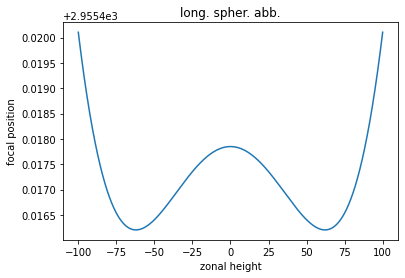

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt

ray_height = -100
xvals=list()
yvals=list()
while ray_height <= 100:
    xvals.append(ray_height)
    yvals.append(meridional_ray_trace(546, f15_airspaced_achro, ray_height, False))
    ray_height += 0.05

plt.title('long. spher. abb.')
plt.ylabel('focal position')
plt.xlabel('zonal height')
plt.plot(xvals, yvals)


### The chromatic focal shift and color curves for the 200mm f/15 achromatic doublet

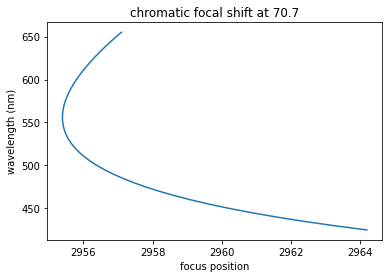

In [60]:
chromatic_focal_shift(486, 656, f15_airspaced_achro, 70.7)

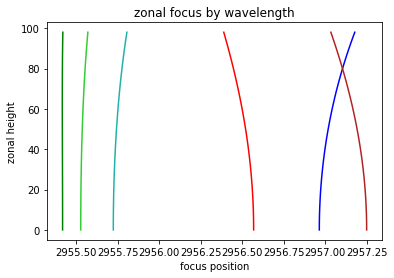

In [61]:
color_curves(f15_airspaced_achro)

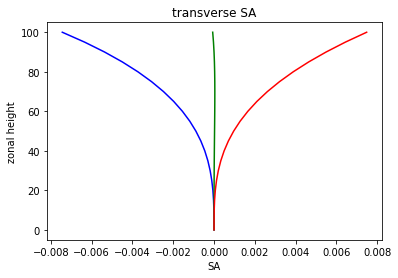

In [62]:
transverse_SA_curve(f15_airspaced_achro)

### The chromatic focal shift curve for an 200mm f/15 apochromatic doublet

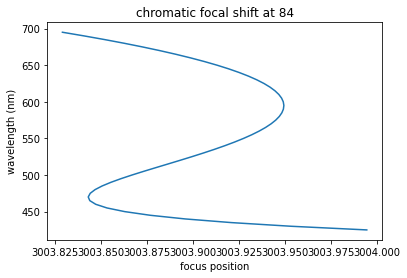

In [63]:
f15_200mm_airspaced_apo=Prescription('''
MED AIR
TH 1e10
RAD 1e10

MED N-ZK7
RAD 1383.366
TH 20

MED AIR
RAD 513.2866
TH 18.10669

MED O-FPL53
RAD 513.2866
TH 30

MED AIR
RAD -4808.375
TH 1e10

''')
chromatic_focal_shift(400, 700, f15_200mm_airspaced_apo, 84)

### Color curves for the f/15 apochromat

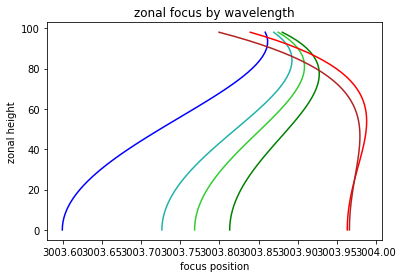

In [64]:
color_curves(f15_200mm_airspaced_apo)

### 200mm f/8 oiled triplet - NPN, chromatic shift and color curves

In [74]:
f8_200mm_oiled_triplet=Prescription('''
MED AIR
TH 1e10
RAD 1e10

MED N-ZK7
RAD 753.6887
TH 20

MED O-FPL53
RAD 434.1788
TH 35

MED N-ZK7
RAD -582.5756
TH 20

MED AIR
RAD -2184.093
TH 1e10

''')

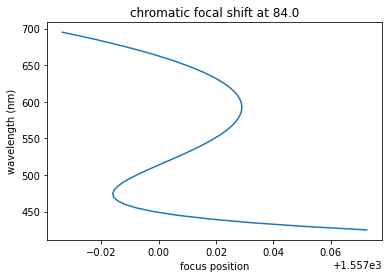

In [75]:
chromatic_focal_shift(400,700, f8_200mm_oiled_triplet,84.0)

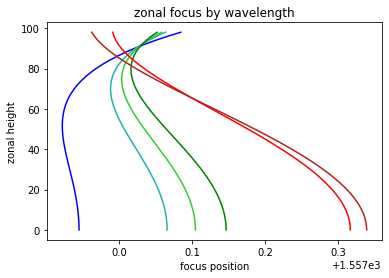

In [76]:
color_curves(f8_200mm_oiled_triplet)

### 200mm f/15 Super achromatic triplet

In [68]:
f15_200mm_super_achro=Prescription('''
MED AIR
TH 1e10
RAD 1e10

MED SK55
RAD 1611.038
TH 27

MED KZFSN4
RAD -650.8718
TH 16

MED N-BAF4
RAD 367.3269
TH 29

MED AIR
RAD 14277.27
TH 1e10
''')


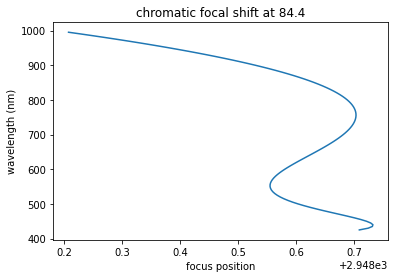

In [69]:
chromatic_focal_shift(400,1000,f15_200mm_super_achro, 84.4)

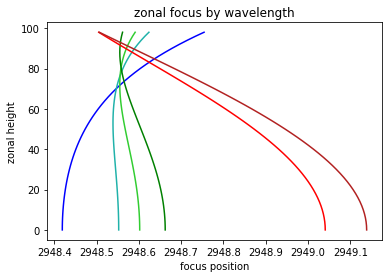

In [70]:
color_curves(f15_200mm_super_achro)

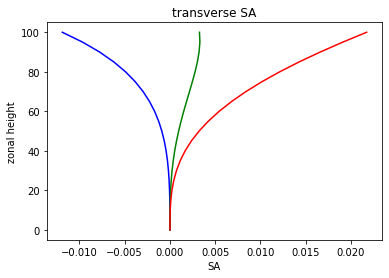

In [29]:
transverse_SA_curve(f15_200mm_super_achro)